In [1]:
import pandas as pd

# Load, make date column datetime datatype, and filter the dataset to one product
df = pd.read_csv("../data/sales_data.csv")
df['date'] = pd.to_datetime(df['date'])
df = df[df['product_line'] == 'Alpha'].sort_values('date')

# Preview the structure
df.head()

,date,product_line,monthly_bookings
0,2021-01-01,Alpha,110051
1,2021-02-01,Alpha,109266
2,2021-03-01,Alpha,116108
3,2021-04-01,Alpha,120895
4,2021-05-01,Alpha,104935


In [2]:
#split 80/20 for training and test data
split_idx = int(len(df) * 0.8)
df_train = df.iloc[:split_idx]
df_test = df.iloc[split_idx:]
#below was debugging as plot was replicating actuals x4 values on merge.
df_train['date'].value_counts().sort_index()

date
2021-01-01    1
2021-02-01    1
2021-03-01    1
2021-04-01    1
2021-05-01    1
2021-06-01    1
2021-07-01    1
2021-08-01    1
2021-09-01    1
2021-10-01    1
2021-11-01    1
2021-12-01    1
2022-01-01    1
2022-02-01    1
2022-03-01    1
2022-04-01    1
2022-05-01    1
2022-06-01    1
2022-07-01    1
2022-08-01    1
2022-09-01    1
2022-10-01    1
2022-11-01    1
2022-12-01    1
2023-01-01    1
2023-02-01    1
2023-03-01    1
2023-04-01    1
Name: count, dtype: int64

In [3]:
# Format for Prophet
df_prophet_train = df_train.rename(columns={'date': 'ds', 'monthly_bookings': 'y'})[['ds', 'y']]
df_prophet_test = df_test.rename(columns={'date': 'ds', 'monthly_bookings': 'y'})[['ds', 'y']]
#below was debugging as plot was replicating actuals x4 values
df_prophet_train['ds'].value_counts().sort_index()

ds
2021-01-01    1
2021-02-01    1
2021-03-01    1
2021-04-01    1
2021-05-01    1
2021-06-01    1
2021-07-01    1
2021-08-01    1
2021-09-01    1
2021-10-01    1
2021-11-01    1
2021-12-01    1
2022-01-01    1
2022-02-01    1
2022-03-01    1
2022-04-01    1
2022-05-01    1
2022-06-01    1
2022-07-01    1
2022-08-01    1
2022-09-01    1
2022-10-01    1
2022-11-01    1
2022-12-01    1
2023-01-01    1
2023-02-01    1
2023-03-01    1
2023-04-01    1
Name: count, dtype: int64

In [4]:
from prophet import Prophet

model_prophet = Prophet()
model_prophet.fit(df_prophet_train)

17:25:05 - cmdstanpy - INFO - Chain [1] start processing
17:25:06 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
# Create Prophet forecast
future = df_prophet_test[['ds']].copy()
forecast = model_prophet.predict(future)

# Match forecast length to df_prophet_test to avoid plot errors
forecast = forecast.iloc[:len(df_prophet_test)].copy()


In [6]:
df_eval_prophet = forecast[['ds', 'yhat']].merge(df_prophet_test[['ds', 'y']], on='ds', how='inner')

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_prophet = mean_absolute_error(df_eval_prophet['y'], df_eval_prophet['yhat'])
rmse_prophet = np.sqrt(mean_squared_error(df_eval_prophet['y'], df_eval_prophet['yhat']))

print(f"Prophet MAE: {mae_prophet:.2f}")
print(f"Prophet RMSE: {rmse_prophet:.2f}")

Prophet MAE: 15806.44
Prophet RMSE: 19587.35


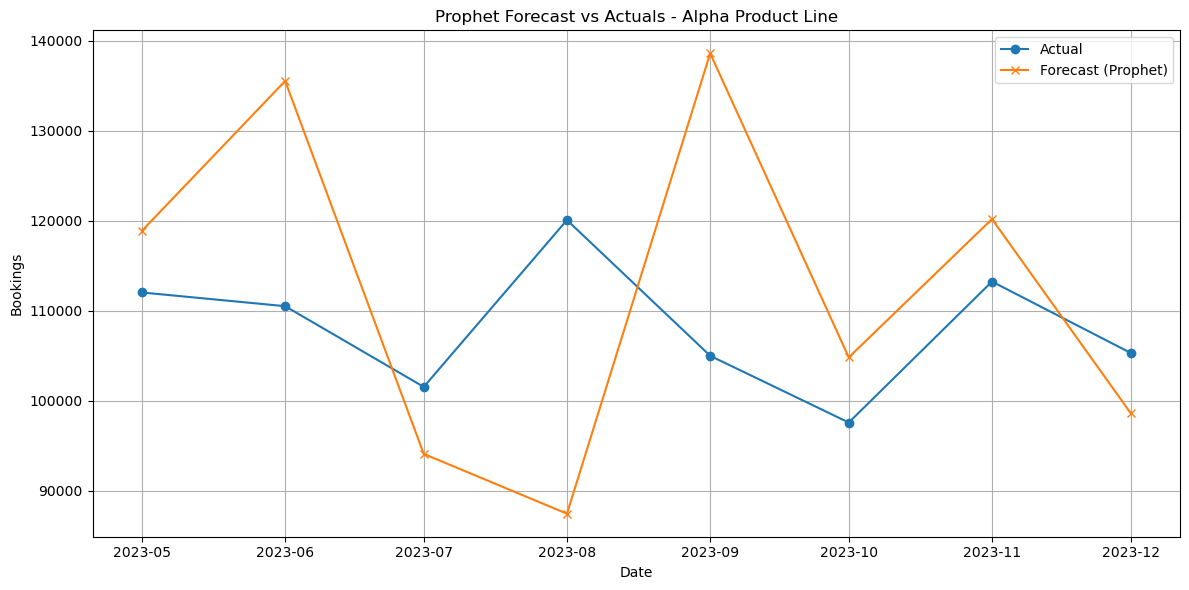

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_eval_prophet['ds'], df_eval_prophet['y'], label='Actual', marker='o')
plt.plot(df_eval_prophet['ds'], df_eval_prophet['yhat'], label='Forecast (Prophet)', marker='x')
plt.title('Prophet Forecast vs Actuals - Alpha Product Line')
plt.xlabel('Date')
plt.ylabel('Bookings')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# Transitioning from Prophet to XGBoost to see if we can improve forecasting accuracy
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [10]:
#Let's XGBoost see previous months's values as predictors
df_xgb_train = df_train.copy()
df_xgb_train = df_xgb_train.set_index('date')

# Create lag features
for lag in [1, 2, 3]:
    df_xgb_train[f'lag_{lag}'] = df_xgb_train['monthly_bookings'].shift(lag)

# Drop rows with NaNs from shifting, this will drop first 3 months as lag has 3 month lookback
df_xgb_train = df_xgb_train.dropna()



In [11]:
X_train = df_xgb_train[['lag_1', 'lag_2', 'lag_3']]
y_train = df_xgb_train['monthly_bookings']

In [20]:
df_xgb_test = df_test.copy()
df_xgb_test = df_xgb_test.set_index('date')

for lag in [1, 2, 3]:
    df_xgb_test[f'lag_{lag}'] = df_xgb_test['monthly_bookings'].shift(lag)

df_xgb_test = df_xgb_test.dropna()

X_test = df_xgb_test[['lag_1', 'lag_2', 'lag_3']]
y_test = df_xgb_test['monthly_bookings']

In [22]:
from xgboost import XGBRegressor

# Recreate and fit the model
model_xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [23]:
predictions = model_xgb.predict(X_test)

print(f"y_test shape: {y_test.shape}")
print(f"predictions shape: {predictions.shape}")

y_test shape: (5,)
predictions shape: (5,)


In [24]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(objective='reg:squarederror')
model_xgb.fit(X_train, y_train)

y_pred = model_xgb.predict(X_test)


In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_xgb = mean_absolute_error(y_test, y_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"XGBoost MAE: {mae_xgb:.2f}")
print(f"XGBoost RMSE: {rmse_xgb:.2f}")




XGBoost MAE: 12622.69
XGBoost RMSE: 14062.70


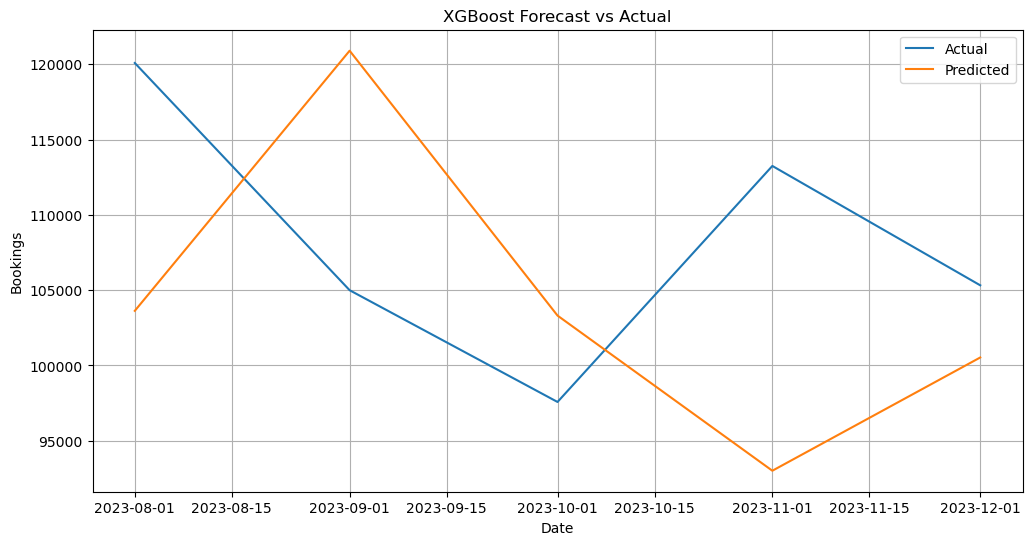

In [26]:
import matplotlib.pyplot as plt

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, predictions, label='Predicted')
plt.title('XGBoost Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Bookings')
plt.legend()
plt.grid(True)
plt.show()

## Model Comparison: Prophet vs XGBoost

We compared two forecasting models using a holdout test set from the Alpha product line.

### 📊 Performance Metrics

**Mean Absolute Error (MAE)** and **Root Mean Squared Error (RMSE)**:

- **Prophet**
  - MAE: $15,806.44
  - RMSE: $19,587.35

- **XGBoost**
  - MAE: $12,622.69
  - RMSE: $14,062.70

### Findings:
- **XGBoost outperformed Prophet** on both MAE and RMSE, indicating it was more accurate at capturing short-term patterns in the sales data.
- Prophet's performance may have been limited due to less seasonality and trend in the data.
- XGBoost's use of recent lagged values likely helped it adapt more quickly to changes in bookings behavior.

### Recommendation:
Use **XGBoost** as the preferred model for short-horizon forecasting in this case, particularly if recent history is a strong driver of future sales. Consider Prophet for longer-term strategic forecasting when clear seasonal or trend components are present.




In [31]:
df_xgb_full = df.copy()
df_xgb_full = df_xgb_full.set_index('date')

for lag in [1, 2, 3]:
    df_xgb_full[f'lag_{lag}'] = df_xgb_full['monthly_bookings'].shift(lag)

df_xgb_full = df_xgb_full.dropna()


In [30]:
X_full = df_xgb_full[['lag_1', 'lag_2', 'lag_3']]
y_full = df_xgb_full['monthly_bookings']

model_xgb.fit(X_full, y_full)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [32]:
last_known = df_xgb_full.copy()

In [38]:
# Forecast 6 future months using XGBoost and lag features
import pandas as pd

n_months = 6
future_preds = []
last_known = df_xgb_full.copy()
last_date = last_known.index.max()

for i in range(n_months):
    latest_vals = last_known['monthly_bookings'].iloc[-3:].values

    next_input = pd.DataFrame([{
        'lag_1': latest_vals[-1],
        'lag_2': latest_vals[-2],
        'lag_3': latest_vals[-3]
    }])

    next_pred = model_xgb.predict(next_input)[0]
    future_preds.append(next_pred)

    next_month = last_date + pd.DateOffset(months=1)
    new_row = pd.DataFrame({'monthly_bookings': [next_pred]}, index=[next_month])
    last_known = pd.concat([last_known, new_row])
    last_date = next_month

In [39]:
# Create DataFrame with forecast results
future_df = pd.DataFrame({
    'date': last_known.index[-6:],
    'forecast_xgb': future_preds
})

# Display it
future_df

,date,forecast_xgb
0,2024-01-01,108206.726562
1,2024-02-01,114883.632812
2,2024-03-01,119823.195312
3,2024-04-01,118893.742188
4,2024-05-01,119778.789062
5,2024-06-01,119230.289062


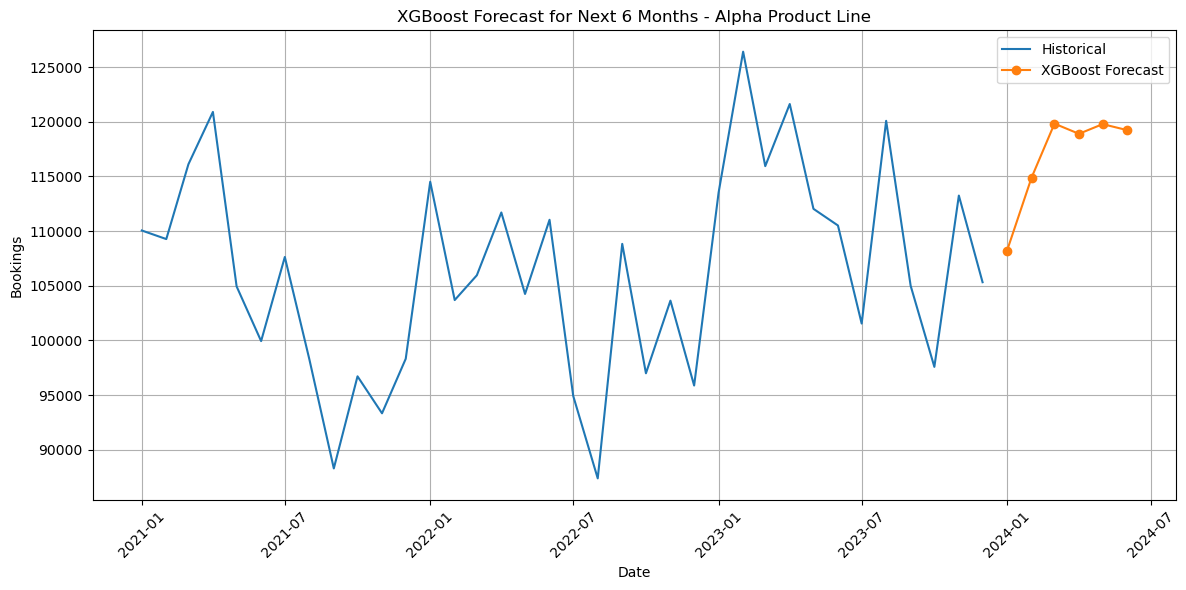

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['monthly_bookings'], label='Historical')
plt.plot(future_df['date'], future_df['forecast_xgb'], label='XGBoost Forecast', marker='o')
plt.title('XGBoost Forecast for Next 6 Months - Alpha Product Line')
plt.xlabel('Date')
plt.ylabel('Bookings')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [41]:
# Reformat forecasted output to match original data structure
future_df_formatted = future_df.copy()

# Rename columns to match original
future_df_formatted.rename(columns={
    'date': 'date',
    'forecast_xgb': 'monthly_bookings'
}, inplace=True)

# Add product_line column
future_df_formatted['product_line'] = 'Alpha'

# Reorder columns to match original source data
future_df_formatted = future_df_formatted[['date', 'product_line', 'monthly_bookings']]

# Display final version
future_df_formatted

,date,product_line,monthly_bookings
0,2024-01-01,Alpha,108206.726562
1,2024-02-01,Alpha,114883.632812
2,2024-03-01,Alpha,119823.195312
3,2024-04-01,Alpha,118893.742188
4,2024-05-01,Alpha,119778.789062
5,2024-06-01,Alpha,119230.289062


## Project Summary

This project used historical monthly bookings for the Alpha product line to forecast future performance.

### Models Used:
- Prophet: A time-series model with trend and seasonality components
- XGBoost: A gradient boosted tree model using three months of lagged features

### Evaluation:
- XGBoost outperformed Prophet based on MAE and RMSE using a holdout test set
- The final XGBoost model was trained on the full dataset and used to forecast six future months

### Deliverables:
- Forecasted values in a table matching the original data schema
- Visualizations comparing actual vs predicted values
- Model comparison summary with performance metrics
- Structured GitHub repository including markdown documentation and a requirements document

This forecast is suitable for short-term planning, resource allocation, and trend tracking. Future improvements may include incorporating additional business drivers, engineering seasonality features, or implementing ensemble models.
